In [9]:
# to_save, to_load = False, True
# session_file = "./tmp/TIC_417436377_EA_contaminated_by_TIC_417436387.pkl"

# # load/save the notebook session
# # https://dill.readthedocs.io/en/latest/
# if True: 
#     import dill
#     dill.load_module(session_file)
#     print(f"Notebook session loaded from  {session_file}")

# if True:  # save the notebook session
#     import dill
#     dill.dump_module(session_file)
#     print(f"Notebook session saved in {session_file}")


In [10]:
import sys
if "../" not in sys.path:  # to get my usual helpers at base dir
    sys.path.append("../")

import lightkurve as lk
from lightkurve_ext import of_sector, of_sectors, of_2min_cadences
import lightkurve_ext as lke
from lightkurve_ext import TransitTimeSpec, TransitTimeSpecList
import lightkurve_ext_tess as lket
import lightkurve_ext_pg as lke_pg
import lightkurve_ext_pg_runner as lke_pg_runner
import tic_plot as tplt

import asyncio_compat

import math
import re
import warnings

import numpy as np
import matplotlib.pyplot as plt
import matplotlib as matplotlib

import pandas as pd
import astropy as astropy
from astropy import units as u
from astropy.coordinates import SkyCoord
from astropy.time import Time, TimeDelta
from astropy.io import fits

from matplotlib.ticker import (FormatStrFormatter, AutoMinorLocator)

from importlib import reload # useful during development to reload packages

from IPython.display import display, HTML, Javascript, clear_output

display(HTML("<style>.container { width:99% !important; }</style>"))  # Jupyter 6
display(HTML("<style>.jp-Notebook { --jp-notebook-max-width: 98%; }</style>"))  # Jupyter 7


# No longer works in Jupyter 7+
display(Javascript("""
// export notebook url to Python for bokeh-based interactive features
if (window["IPython"] != null) {
  IPython.notebook.kernel.execute(`notebook_url = "${window.location.origin}"`);
} else {
  console.warn("IPython js object not available (in Jupyter 7). Hardcode notebook_url in the notebook itself instead.")
}
"""));
notebook_url = "localhost:8888"

%matplotlib inline

# data cache config
lk_download_dir = '../data'
if hasattr(lk, "conf"):  # default download dir
    lk.conf.cache_dir = lk_download_dir

# make markdown table aligned to the left of the cell output (instead of center)
display(HTML("<style>table {margin-left: 4ch;}</style>"))

<IPython.core.display.Javascript object>

# TIC 417436377 / Gaia DR3 2171411293075773952 / HD 235542B Analysis (EA)

- revise existing https://www.aavso.org/vsx/index.php?view=detail.top&oid=13085 , which (incorrectly) points to the nearby TIC 417436387 / HD 235542A
- revision is primarily on identification (so no new epoch / period)

## TESS Data



In [11]:
tic = 417436377

sr = lk.search_lightcurve(f"TIC{tic}", )  # author="SPOC", cadence="short"
sr = lke.filter_by_priority(sr, author_priority = ["SPOC", "TESS-SPOC", "QLP"])

astropy.table.pprint.conf.max_lines = 100  # to print all rows
display(sr)

lcc_tess = sr.download_all()
lcc_tess

#,mission,year,author,exptime,target_name,distance,proposal_id
,,,,s,,arcsec,
0,TESS Sector 15,2019,QLP,1800,417436377,0.0,N/A
1,TESS Sector 16,2019,QLP,1800,417436377,0.0,N/A
2,TESS Sector 56,2022,QLP,200,417436377,0.0,N/A
3,TESS Sector 57,2022,QLP,200,417436377,0.0,N/A
4,TESS Sector 76,2024,QLP,200,417436377,0.0,N/A
5,TESS Sector 77,2024,QLP,200,417436377,0.0,N/A


LightCurveCollection of 6 objects:
    0: <TessLightCurve LABEL="TIC 417436377" SECTOR=15 AUTHOR=QLP FLUX_ORIGIN=sap_flux>
    1: <TessLightCurve LABEL="TIC 417436377" SECTOR=16 AUTHOR=QLP FLUX_ORIGIN=sap_flux>
    2: <TessLightCurve LABEL="TIC 417436377" SECTOR=56 AUTHOR=QLP FLUX_ORIGIN=sap_flux>
    3: <TessLightCurve LABEL="TIC 417436377" SECTOR=57 AUTHOR=QLP FLUX_ORIGIN=sap_flux>
    4: <TessLightCurve LABEL="TIC 417436377" SECTOR=76 AUTHOR=QLP FLUX_ORIGIN=sap_flux>
    5: <TessLightCurve LABEL="TIC 417436377" SECTOR=77 AUTHOR=QLP FLUX_ORIGIN=sap_flux>

In [12]:
# List of all TCEs of the TIC
display(HTML(lket.get_tic_meta_in_html(tic, download_dir=lk_download_dir)))

RS (in R☉),nan
MS (in M☉),nan
Magnitude (TESS),9.19
T_eff (in K),nan


Note: the TCE of the contaminated TIC 417436387
- https://exo.mast.stsci.edu/exomast_planet.html?planet=TIC417436387S0014S0060TCE1
- dvs: https://mast.stsci.edu/api/v0.1/Download/file/?uri=mast:TESS/product/tess2019199201929-s0014-s0060-0000000417436387-01-00692_dvs.pdf


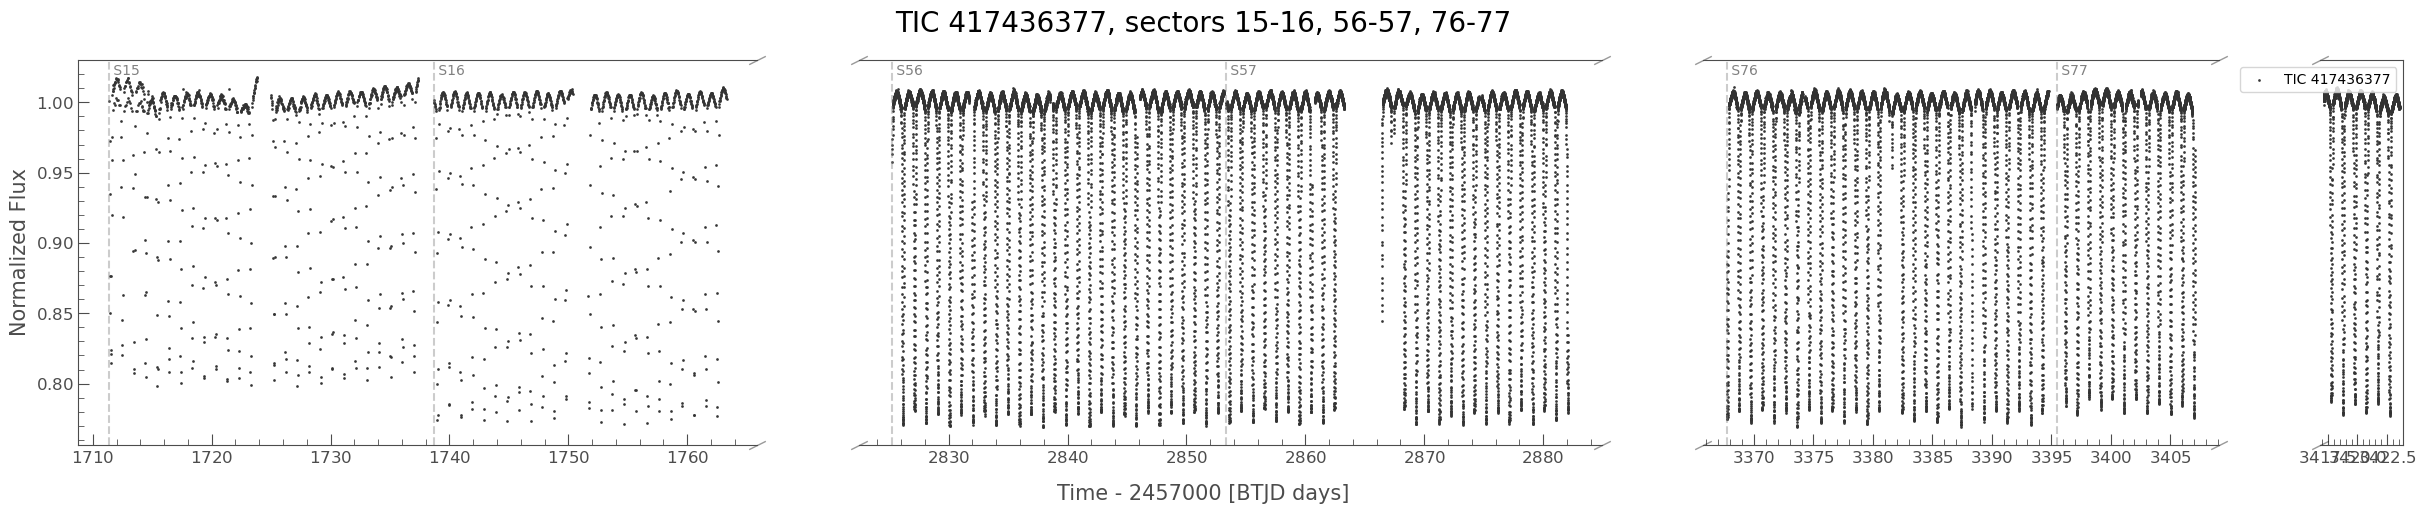

In [13]:
lc = lke.stitch(
    lcc_tess,
    ignore_incompatible_column_warning=True,    
)

axs = tplt.plot_skip_data_gap(lc, figsize=(30,5), s=4, alpha=0.9);
axs[0].get_figure().suptitle(f"{lc.label}, sectors {lke.abbrev_sector_list(lc)}", fontsize=20);

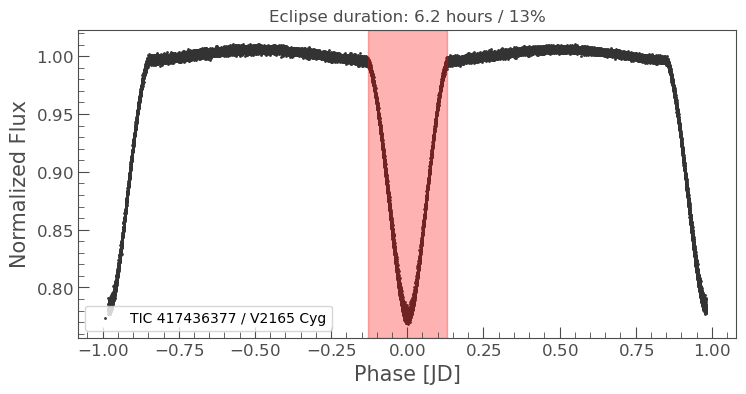

In [14]:
# verify eclipse duration

lc = lke.stitch(
    lcc_tess[2:],  # excluding the 30 minute cadence data, as the amplitude is slightly different
    ignore_incompatible_column_warning=True,    
)

# epoch=1738.99, duration_hr=6.44607, period=0.981189, label="s0014s0060tce1", transit_depth_percent=20.7912,
lc_f = lc.fold(epoch_time=1738.98, period=1.96239)
lc_f.label = f"TIC {tic} / V2165 Cyg"

ax = lc_f.scatter();

dur_hr = 6.2
dur_pct = dur_hr / 24 / 1.96239 * 100
ax.axvspan(0 - dur_hr / 24 / 2, 0 + dur_hr / 24 / 2, color="red", alpha=0.3);
# ax.set_xlim(-0.5, 0.5);
ax.legend(loc="lower left")
ax.set_title(f"Eclipse duration: {dur_hr} hours / {dur_pct:.0f}%");

---

## Gaia DR3 info (coordinate, etc.)

In [15]:
rs_all_cols, rs, rs_html  = lket.search_gaiadr3_of_tics(tic, radius_arcsec=15, magnitude_range=None,  pm_error_factor=None, pm_range_fraction=None, pm_range_minimum=1.0, compact_columns=True, also_return_html=True, also_return_astrophysical=False, verbose_html=True, include_nss_summary_in_html=False)
display(HTML(rs_html))

# from Gaia DR3
target_coord = SkyCoord(rs[0]["RAJ2000"], rs[0]["DEJ2000"], unit=(u.deg, u.deg), frame="icrs")
target_coord_dict = dict(ra=target_coord.ra.value, dec=target_coord.dec.value)


In [16]:
primary_name = f"V2165 Cyg"  # Gaia DR3 Variable has already published about it, even though the data used is from TESS and ASAS-SN


## Hipparcos data

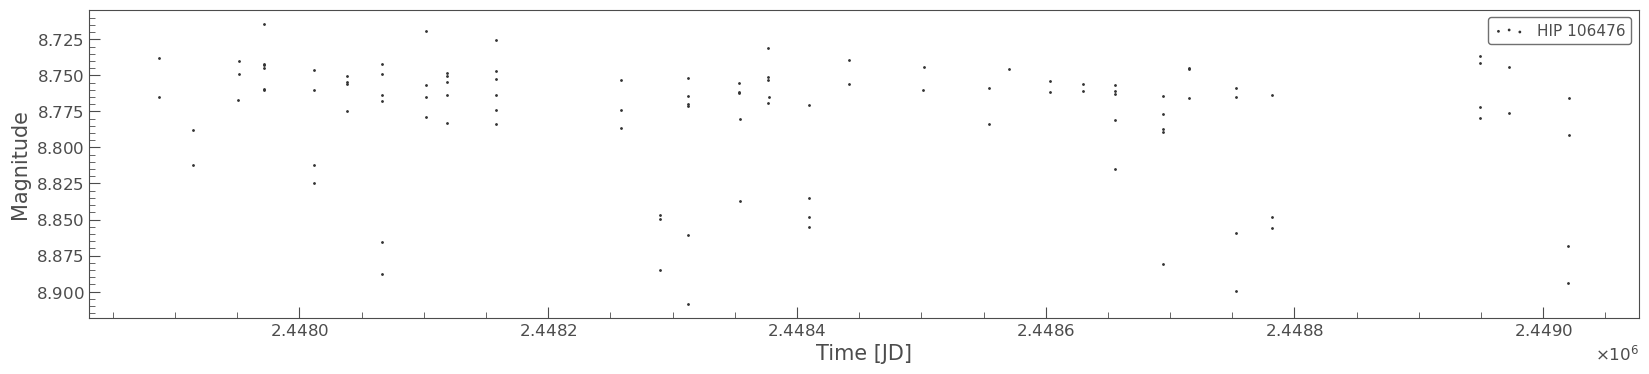

In [17]:
import lightkurve_ext_readers as lker
# reload(lker)

# https://vizier.cds.unistra.fr/viz-bin/VizieR-5?-ref=VIZ63a724f430cc2&-out.add=.&-source=I/239/hip_main&recno=106382
lc = lker.read_hipparcos_data("https://cdsarc.cds.unistra.fr/viz-bin/nph-Plot/Vgraph/txt?I/239/106476")

ax = tplt.lk_ax(figsize=(20, 4))
ax = tplt.scatter(lc, ax=ax);
ax.set_title(ax.get_title());

lc_hip = lc  # keep the reference in a meaninfgul name for use in subsequent cells

## Integarl-OMC data

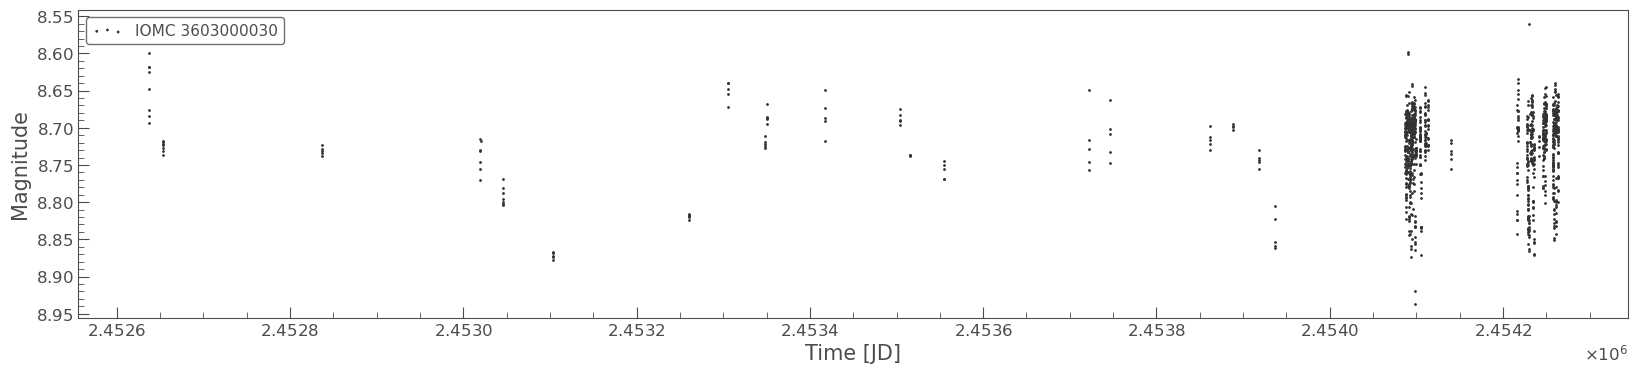

In [18]:
import lightkurve_ext_readers as lker
reload(lker)

# from IOMC name: 
# https://sdc.cab.inta-csic.es/omc/var/3603000030.html
# https://vizier.cds.unistra.fr/viz-bin/VizieR-5?-ref=VIZ66ce45b5ffbb6&-out.add=.&-source=J/A%2bA/548/A79/omc-var&recno=4896
lc = lker.read_integral_omc_var_data("https://cdsarc.cds.unistra.fr/viz-bin/nph-Plot/Vgraph/txt?J/A+A/548/A79/3603000030")

ax = tplt.lk_ax(figsize=(20, 4))
ax = tplt.scatter(lc, ax=ax);
ax.set_title(ax.get_title());

lc_iomc = lc  # keep the reference in a meaninfgul name for use in subsequent cells

## Combining all data

TESS # data points: 43962
Hipparcos # data points: 109
INTEGRAL-OMC # data points: 1074


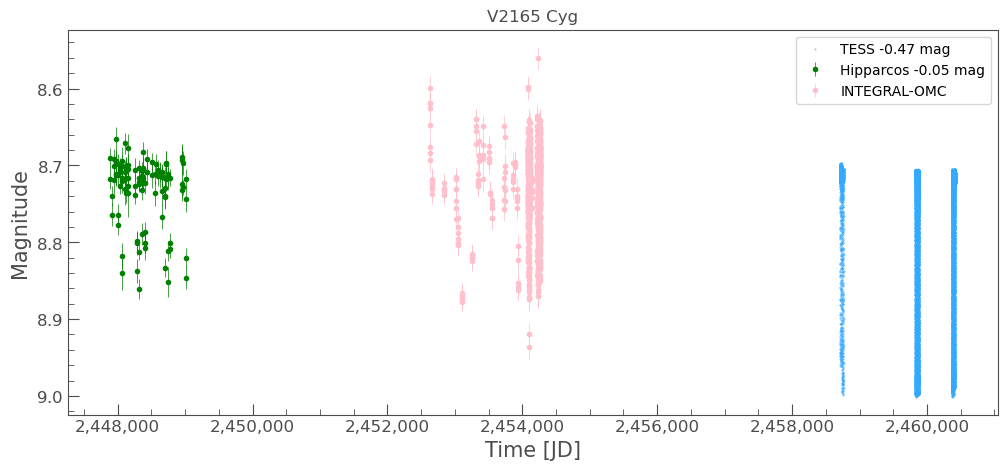

In [19]:
# Convert the data to magnitude and HJD/UTC

import lightkurve_ext_multi_sources as lkem
# reload(lkem)

lc_tess = lke.stitch(lcc_tess, ignore_incompatible_column_warning=True, )

lc_tess = lke.convert_lc_time_to_hjd_utc(lc_tess, target_coord=target_coord, cache_dir=lk_download_dir)
lc_tess = lke.to_flux_in_mag_by_normalization(lc_tess)
# axs = tplt.plot_skip_data_gap(lc_tess, figsize=(30,5), s=4, alpha=0.9);

lc_combined_dict = lkem.combine_multi_bands_and_shift(
    {"TESS": lc_tess, 
     "Hipparcos": lc_hip,
     "INTEGRAL-OMC": lc_iomc,
    }, 
    shift_to="INTEGRAL-OMC"  # 
)

for k in lc_combined_dict.keys():
    print(f"{k} # data points:", len(lc_combined_dict[k]))

ax = lkem.plot_multi_bands(lc_combined_dict, figsize=(12, 5), target_name=primary_name);


## Determine epoch / period / duration by using combined data

In [20]:
# epoch=3287.5580, duration_hr=3.3745, period=2.039652, label="s0073-s0073:TCE1",

#
# Tentative Eclipse parameters, from s0003-s0073:TCE1 above
#

period_initial = 1.96239 # VSX value

#
# Epoch: TESS EB value fits the best (better than existing VSX value and TCE) 
#
# epoch_time_btjd = 1738.986  # from TCE
epoch_time_btjd  = 1738.980  # TESS EB, TESS EB value 
epoch_time_hjd = lke.to_hjd_utc(Time(epoch_time_btjd, format="btjd"), target_coord).value  
epoch_time_hjd = round(epoch_time_hjd, 3)  # for VSX reporting, 3 digit precision (~1.44 min) is more than enough

# epoch_time_hjd =Time(2448501.198, format="jd", scale="utc"),  # existing epoch in VSX

epoch_time_min_ii_btjd = epoch_time_btjd + period_initial / 2
epoch_time_min_ii_hjd = lke.to_hjd_utc(Time(epoch_time_min_ii_btjd, format="btjd"), target_coord).value
epoch_time_min_ii_hjd = round(epoch_time_min_ii_hjd, 3)  # for VSX reporting, 3 digit precision (~1.44 min) is more than enough

duration_hr_min_i_initial = 6.2  
duration_hr_min_ii_initial = 6.2
duration_hr = duration_hr_min_i_initial   # default shorthand 

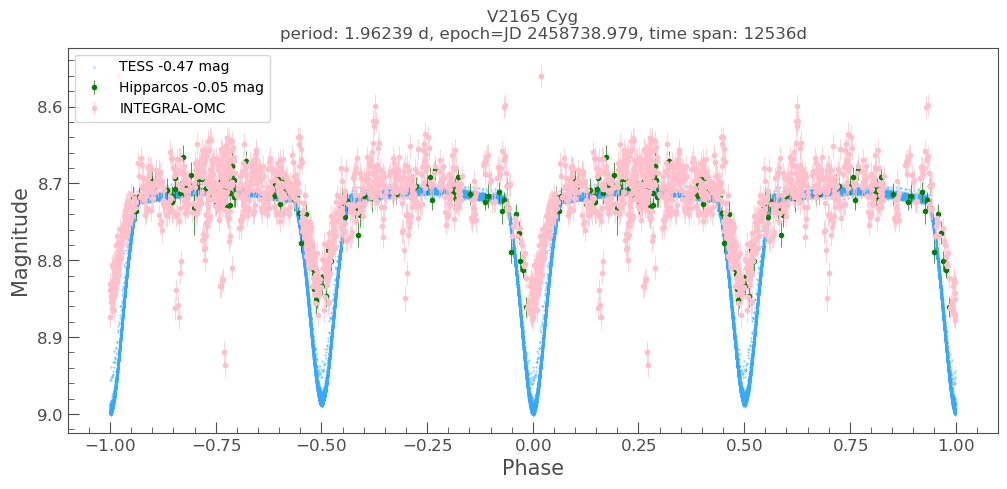

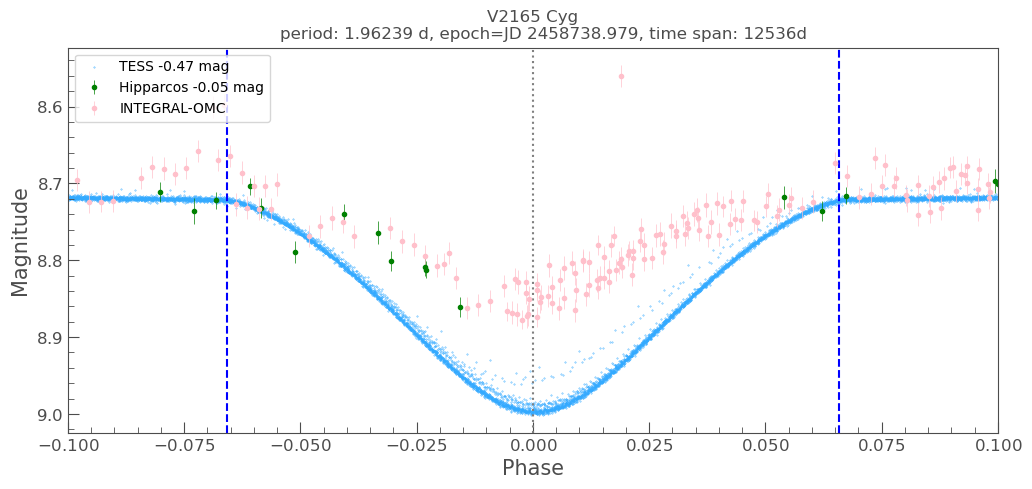

In [21]:
%matplotlib inline
# %matplotlib widget

# reload(lkem)
ax, lc_f_res = lkem.fold_n_plot_multi_bands(
    lc_combined_dict,
    period=period_initial,
    # epoch=Time(2448501.198, format="jd", scale="utc"),  # existing VSX value
    epoch=Time(epoch_time_hjd, format="jd", scale="utc"),
    phase_scale=2,  #  fold at  period, i.e., plot from phase -1 to +1
    target_name=primary_name,
    # duration_hr=duration_hr_min_i_initial,  # for plotting only
    figsize=(12, 5),
    mag_shift_precision=2,  # the TESS lightcurve is very rough anyway
);


# zoom plot
ax, lc_f_res = lkem.fold_n_plot_multi_bands(
    lc_combined_dict,
    period=period_initial,
    # epoch=Time(2448501.198, format="jd", scale="utc"),  # existing VSX value
    epoch=Time(epoch_time_hjd, format="jd", scale="utc"),
    phase_scale=2,  #  fold at  period, i.e., plot from phase -1 to +1
    target_name=primary_name,
    duration_hr=duration_hr_min_i_initial,  # for plotting only
    figsize=(12, 5),
    mag_shift_precision=2,  # the TESS lightcurve is very rough anyway
);
ax.legend(loc="upper left");
ax.axvline(0, c="gray", linestyle="dotted");
ax.set_xlim(-0.1, 0.1);  # to see primary in details

In [22]:
# Cannot tell the difference between TCE period and BLS period, cut 1 digit and choose the best
period_final = period_initial
print("Adopted period: ", period_final)

# Can precsiely define Min II phase, with period finalized
epoch_phase_min_ii = (epoch_time_min_ii_btjd - epoch_time_btjd) / period_final
print("Min II phase: ", epoch_phase_min_ii)

Adopted period:  1.96239
Min II phase:  0.500000000000036


## Determine Amplitude (TESS)

['9.19', '9.46', '9.46']
['9.19', '0.28', '0.27']


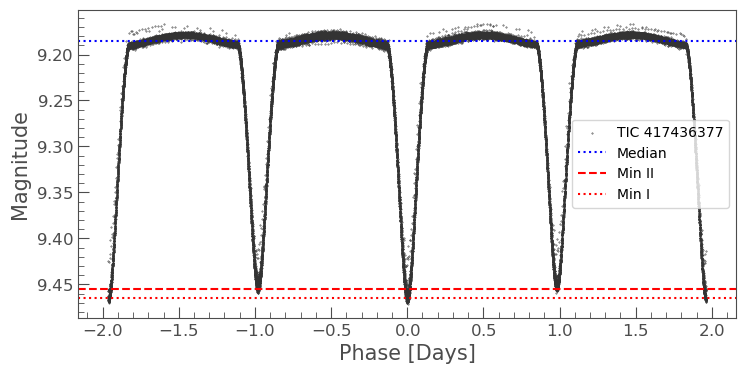

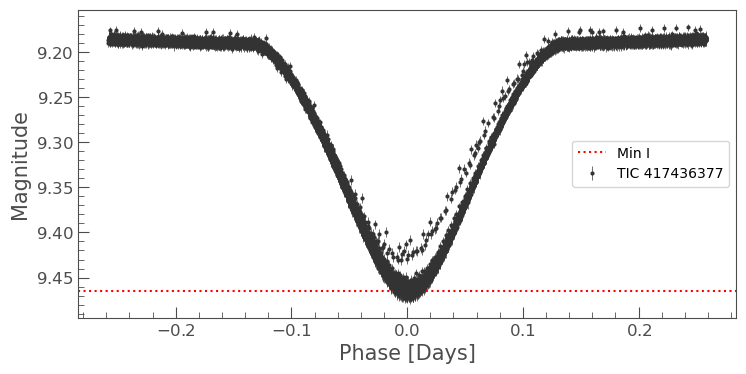

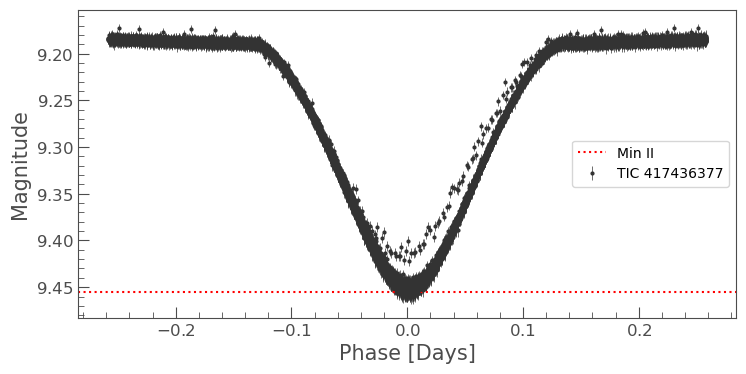

In [23]:
# From TESS data (shifted back to TESS mag)

lc = lc_combined_dict["TESS"]
lc = lc - lc.flux_shift
# max_flux_mag = lc.flux.min().value  #
min_flux_mag = lc.flux.max().value
median_flux_mag = np.nanmedian(lc.flux.value)

lc_zoom_min = lc.fold(epoch_time=epoch_time_hjd, period=period_final).truncate(0 - 0.25/24/60, 0 + 0.25/24/60)
min_flux_mag = np.nanmedian(lc_zoom_min.flux.value)
min_amp_mag = abs(min_flux_mag - median_flux_mag) 

# fold around Min II, find the min flux
lc_zoom_min_ii = lc.fold(epoch_time=epoch_time_min_ii_hjd, period=period_final).truncate(0 - 0.25/24/60, 0 + 0.25/24/60)
min_ii_flux_mag = np.nanmedian(lc_zoom_min_ii.flux.value)
min_ii_amp_mag = abs(min_ii_flux_mag - median_flux_mag) 

lc_f = lc.fold(epoch_time=epoch_time_hjd, period=period_final * 2)  # 2x period plot
ax = tplt.scatter(lc_f, s=0.5);
ax.axhline(median_flux_mag, c="blue", linestyle="dotted", label="Median")
ax.axhline(min_ii_flux_mag, c="red", linestyle="dashed", label="Min II")
ax.axhline(min_flux_mag, c="red", linestyle="dotted", label="Min I")
ax.legend();

lc_f_zoom_min_i = lc.fold(epoch_time=epoch_time_hjd, period=period_final).truncate(0 - duration_hr / 24, 0 + duration_hr / 24)
ax = tplt.errorbar(lc_f_zoom_min_i, marker="o");
ax.axhline(min_flux_mag, c="red", linestyle="dotted", label="Min I")
ax.legend();

lc_f_zoom_min_ii = lc.fold(epoch_time=epoch_time_min_ii_hjd, period=period_final).truncate(0 - duration_hr_min_ii_initial / 24, 0 + duration_hr_min_ii_initial / 24)
ax = tplt.errorbar(lc_f_zoom_min_ii, marker="o");
ax.axhline(min_ii_flux_mag, c="red", linestyle="dotted", label="Min II")
ax.legend();

print([f"{v:.2f}" for v in [median_flux_mag, min_flux_mag, min_ii_flux_mag]])
print([f"{v:.2f}" for v in [median_flux_mag, min_amp_mag, min_ii_amp_mag]])

## Plots for VSX

In [24]:
# reload(lkem)
# Not needed
# ax = lkem.plot_multi_bands(lc_combined_dict, figsize=(24, 10), target_name=primary_name);

#### Phase Plot, no crowding correction 

- for reference, not used in submission

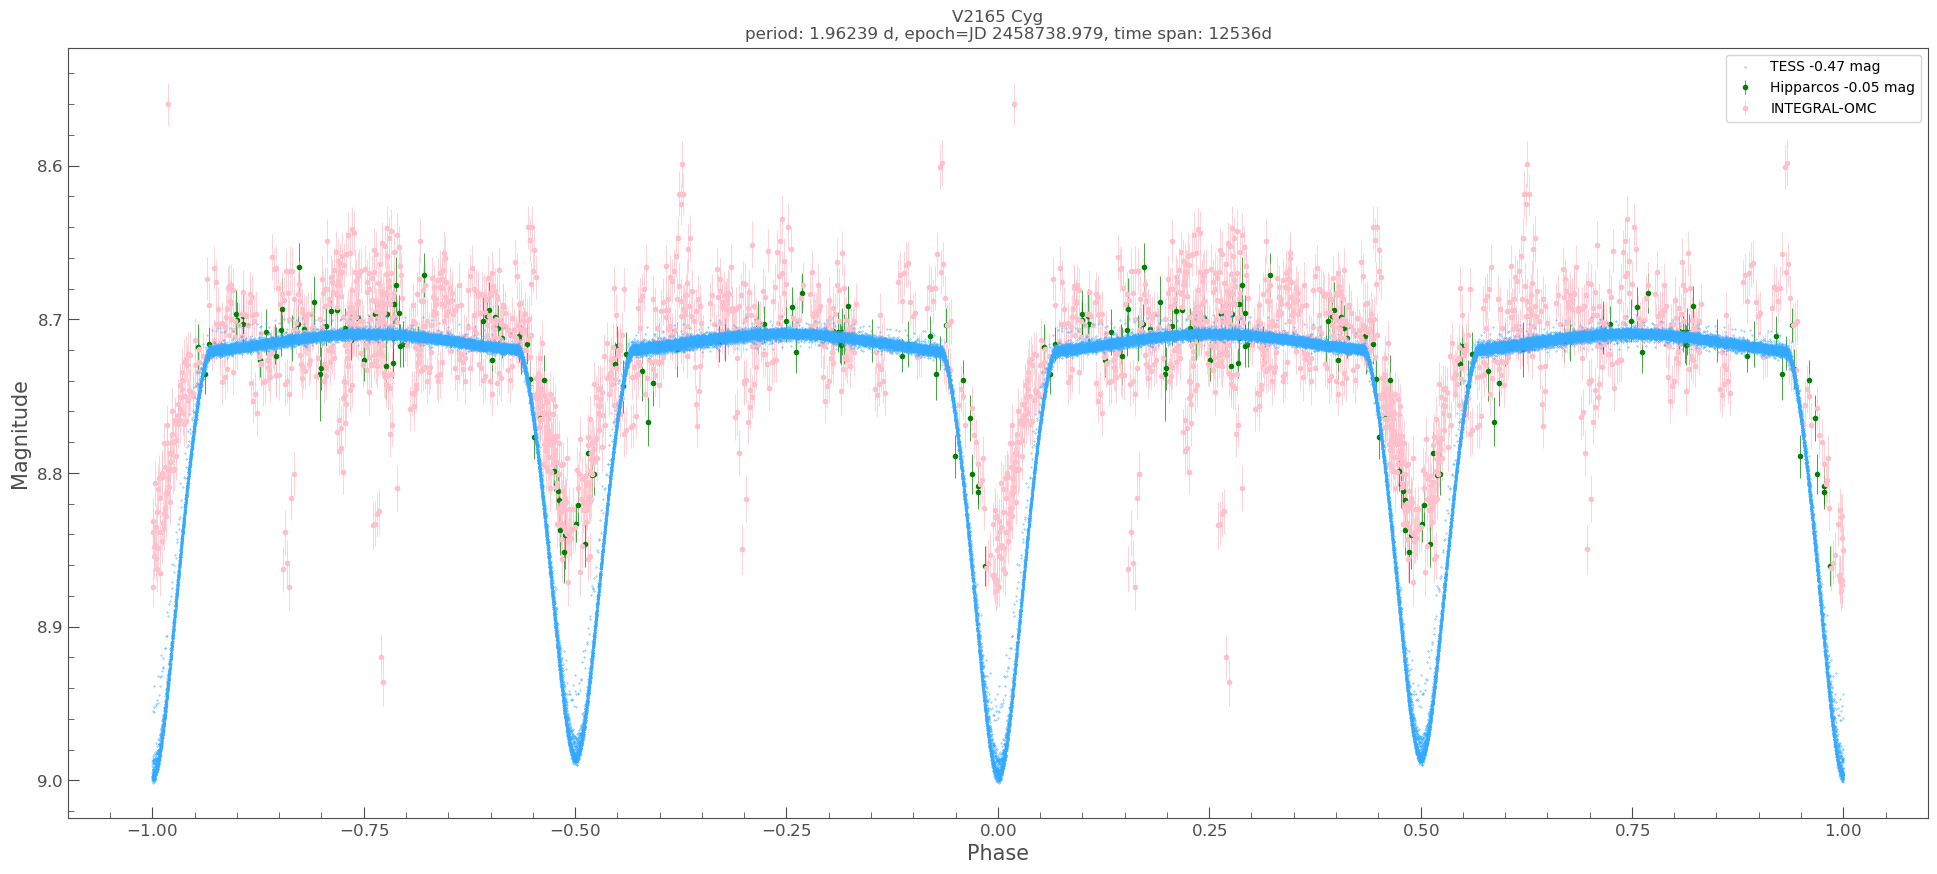

In [26]:
# reload(lkem)

plot_options = lkem.get_default_plot_multi_bands_options_copy()
# for TESS plot (index 0) increase the marker size and move it to the front, to make TESS data more visible, its data is not rather sparse
# plot_options[0][1]["s"] = 0.1  # default 0.1
plot_options[0][1]["zorder"] = 3  # default 2

ax, lc_f_res = lkem.fold_n_plot_multi_bands(
    lc_combined_dict,
    period=period_final,
    epoch=Time(epoch_time_hjd, format="jd", scale="utc"),
    # epoch=Time(2448501.198, format="jd", scale="utc"),  # existing epoch in VSX
    phase_scale=2,  #  fold at  period, i.e., plot from phase -1 to +1    
    figsize=(24, 10),
    target_name=primary_name,
    plot_options=plot_options,
);


### Phase plot with crowding-corrected INTEGRAL-OMC

#### Determine contaminant V mag

Use transformd V mag from Gaia DR3 Gmag, with zero point adjustment using combined  Vmag max in INTEGRAL-OMC and Hipparcos as the reference.

In [148]:
# V max in in INTEGRAL-OMC: 8.70 (lightcurve inspection)
# Hg max in Hippracos: 8.753
# transformed V max in Hippracos: 
# = 8.867  , if B-V == 0.223 (dedcued from Gaia DR3), or
# = 8.686 , if B-V = 0.2228 (using Tycho derived data, but Tycho coloar data isn't gooed, espeically those without GCPD  (General Catalogue of Photometric Data)
#
# bottom line: though not precise, transformed V max in Hippracos is probably < 8.70
# the combined V max is thus approximated as 8.695
combined_v_mag_max  = 8.695

In [149]:
target_g_vmag_max = lke.gaia_dr3_mag_to_vmag(9.38, 0.377)  # max of 9.38 is from visual inspection Gaia DR3 photometry
print("target V max from Gaia G:", target_g_vmag_max)

contaminant_g_vmag = lke.gaia_dr3_mag_to_vmag(9.380, 0.395)  # from Gaia DR3 Gmag and B-R 
print("contaminant V from Gaia G:", contaminant_g_vmag)  

combined_g_vmag_max= lke.combine_magnitudes(target_g_vmag_max, contaminant_g_vmag)
print("Combined max V from Gaia G:", combined_g_vmag_max)

zero_point_offset = combined_v_mag_max - combined_g_vmag_max
print("Zero point offset:", zero_point_offset)

contaminant_vmag = contaminant_g_vmag + zero_point_offset
contaminant_vmag = round(contaminant_vmag, 2)
print("Contaminant Vmag, zero point adjusted, rounded:", contaminant_vmag)

target V max from Gaia G: 9.431550444053421
contaminant V from Gaia G: 9.434175347982501
Combined max V from Gaia G: 8.680287113603748
Zero point offset: 0.01471288639625179
Contaminant Vmag, zero point adjusted, rounded: 9.45


#### Beblend INTEGRAL-OMC data; Transform and deblend Hipparacos data; then Phase Plot

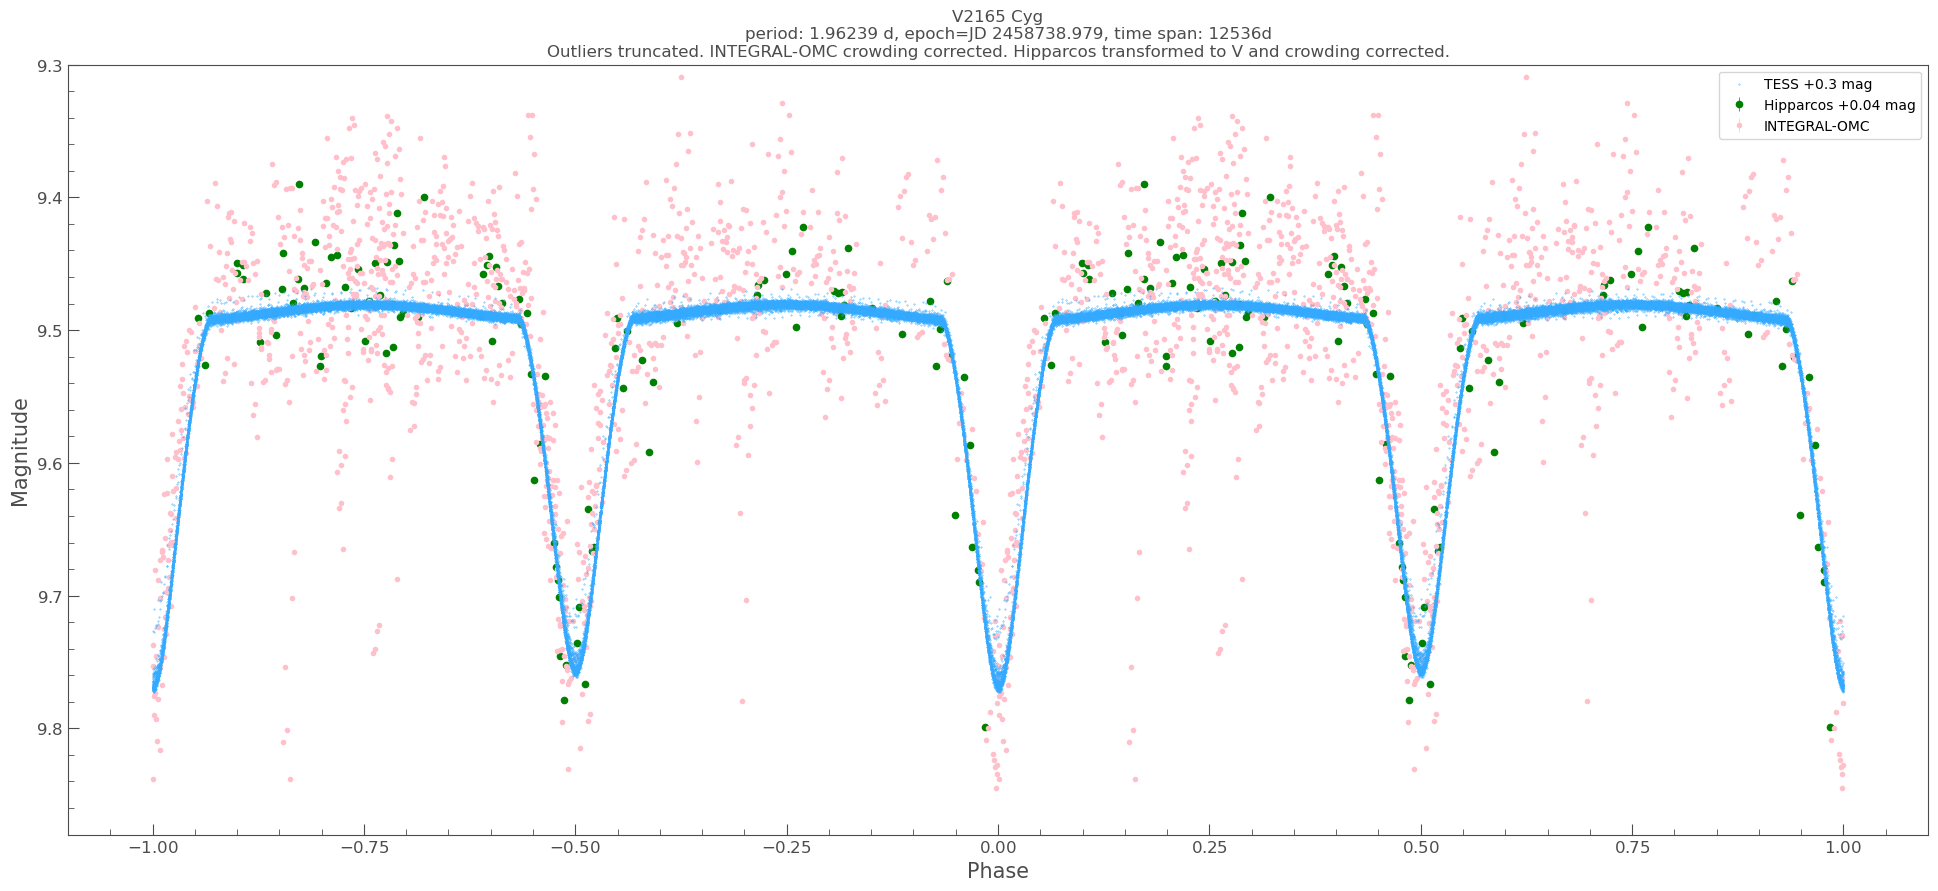

In [169]:
# reload(lke)
lc_iomc_c = lke.deblend_mag(lc_iomc, contaminant_vmag)

lc_hip_v = lc_hip.copy()
hg_to_v_correction = -0.066  # from Hp to V conversion for B-V= 0.223 (estimates from Sebatsian O.)
lc_hip_v.flux = lc_hip_v.flux + hg_to_v_correction * u.mag
lc_hip_v_c = lke.deblend_mag(lc_hip_v, contaminant_vmag)

lc_combined_dict_c = lkem.combine_multi_bands_and_shift(
    {"TESS": lc_tess, 
     "Hipparcos": lc_hip_v_c,
     "INTEGRAL-OMC": lc_iomc_c,
    }, 
    shift_to="INTEGRAL-OMC"  # it's native V-band
)

plot_options = lkem.get_default_plot_multi_bands_options_copy()
# for TESS plot (index 0) increase the marker size and move it to the front, to make TESS data more visible, its data is not rather sparse
# plot_options[0][1]["s"] = 0.1  # default 0.1
plot_options[0][1]["zorder"] = 3  # default 2
plot_options[1][1]["markersize"] = 9  # make markers for Hp larger

ax, lc_f_res = lkem.fold_n_plot_multi_bands(
    lc_combined_dict_c,
    period=period_final,
    epoch=Time(epoch_time_hjd , format="jd", scale="utc"),
    # epoch=Time(2448501.198, format="jd", scale="utc"),  # existing epoch in VSX
    phase_scale=2,  #  fold at  period, i.e., plot from phase -1 to +1    
    figsize=(24, 10),
    target_name=primary_name,
    plot_options=plot_options,
);
ax.set_ylim(9.88, 9.30);
ax.set_title(ax.get_title() + "\nOutliers truncated. INTEGRAL-OMC crowding corrected. Hipparcos transformed to V and crowding corrected.");

# # zoom to Min I
# # 9.77: fainter end of shfifted TESS, taking into INTEGRAL-OMC data into account 
# ax.axhline(9.77, c="blue", linestyle="--", label="Min I"); ax.set_xlim(-0.1, 0.1); ax.axvline(0, c="gray", linestyle="dotted");  

# # zoom to max, 
# # 9.47: slightly brighter than shfifted TESS (~9.48), but INTEGRAL-OMC might suggest shfited TESS might be a bit too faint
# ax.axhline(9.47, c="blue", linestyle="--", label="Min I"); ax.set_xlim(0.05, 0.45); ax.set_ylim(9.6, 9.3); ax.axvline(0.25, c="gray", linestyle="dotted");  

In [ ]:
# Copy the deblending result to VSX deblend spreadsheet to ensure the implementaion is correct
# lc_iomc.to_pandas().to_clipboard()
# lc_iomc_c.to_pandas()["flux"].to_clipboard()


### Determine Magnitude Range (crowding corrected INTEGRAL-OMC)

Min mag # num data points: 17
Max mag # num data points: 14
['9.46', '9.78']


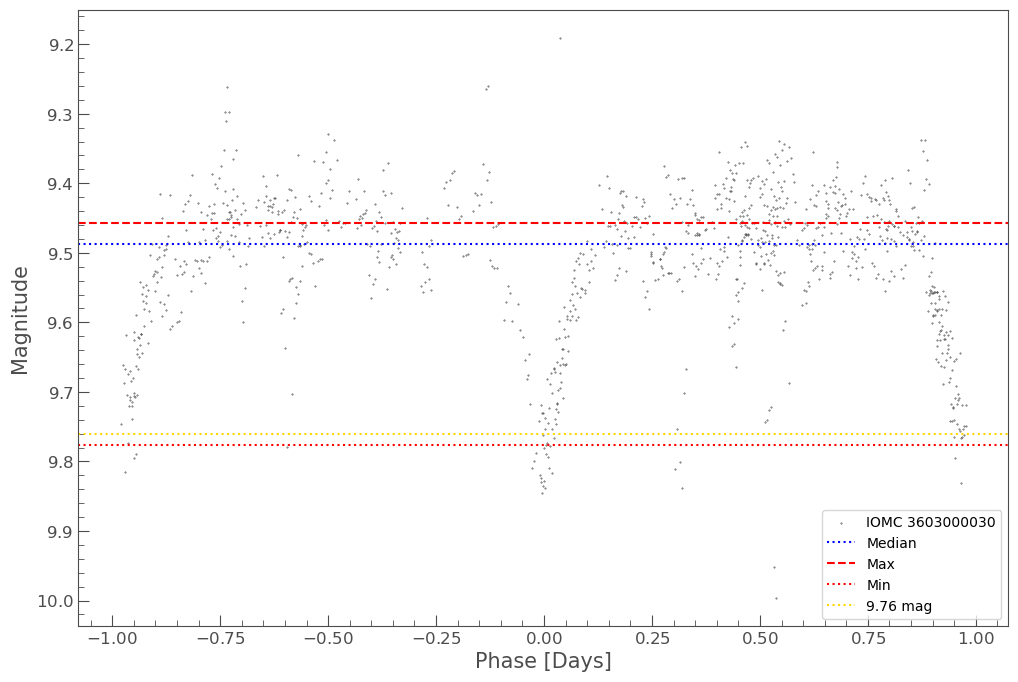

In [160]:
# %matplotlib widget
%matplotlib inline

# From TESS data (shifted back to TESS mag)

lc = lc_combined_dict_c["INTEGRAL-OMC"]
# max_flux_mag = lc.flux.min().value  #
# min_flux_mag = lc.flux.max().value
median_flux_mag = np.nanmedian(lc.flux.value)

lc_zoom_min = lc.fold(epoch_time=epoch_time_hjd, period=period_final).truncate(0 - 12/24/60, 0 + 12/24/60)
print("Min mag # num data points:", len(lc_zoom_min))
min_flux_mag = np.nanmedian(lc_zoom_min.flux.value)

# fold around Min II, find the min flux
lc_zoom_max_p1 = lc.fold(epoch_time=epoch_time_hjd + period_final * 0.25, period=period_final).truncate(0 - 12/24/60, 0 + 12/24/60)
lc_zoom_max_p2 = lc.fold(epoch_time=epoch_time_hjd + period_final * 0.75, period=period_final).truncate(0 - 12/24/60, 0 + 12/24/60)
lc_zoom_max = lk.LightCurveCollection([lc_zoom_max_p1, lc_zoom_max_p2]).stitch(corrector_func=lambda lc: lc)
print("Max mag # num data points:", len(lc_zoom_max))
max_flux_mag = np.nanmedian(lc_zoom_max.flux.value)

lc_f = lc.fold(epoch_time=epoch_time_hjd, period=period_final * 1)  # 2x period plot
ax = tplt.lk_ax(figsize=(12, 8))
ax = tplt.scatter(lc_f, s=0.5, ax=ax);
ax.axhline(median_flux_mag, c="blue", linestyle="dotted", label="Median")
ax.axhline(max_flux_mag, c="red", linestyle="dashed", label="Max")
ax.axhline(min_flux_mag, c="red", linestyle="dotted", label="Min")
ax.axhline(9.76, c="gold", linestyle="dotted", label="9.76 mag")  # the min suggested by sebatsian
ax.legend(loc="lower right");
# ax.set_xlim(-0.15, 0.15); ax.set_ylim(9.85, 9.3);  ax.axvline(0, c="gray", linestyle="dotted");  # zoom to Min

# lc_f_zoom_min_i = lc.fold(epoch_time=epoch_time_hjd, period=period_final).truncate(0 - duration_hr / 24, 0 + duration_hr / 24)
# ax = tplt.errorbar(lc_f_zoom_min_i, marker="o");
# ax.axhline(min_flux_mag, c="red", linestyle="dotted", label="Min I")
# ax.legend();

# lc_f_zoom_min_ii = lc.fold(epoch_time=epoch_time_min_ii_hjd, period=period_final).truncate(0 - duration_hr_min_ii_initial / 24, 0 + duration_hr_min_ii_initial / 24)
# ax = tplt.errorbar(lc_f_zoom_min_ii, marker="o");
# ax.axhline(min_ii_flux_mag, c="red", linestyle="dotted", label="Min II")
# ax.legend(loc="lower right");

# Sebatsian suggestion: 9.46 - 9.76, based on corrected Hipparcos, INTEGRAL-OMC
print([f"{v:.2f}" for v in [max_flux_mag, min_flux_mag]])


## VSX Report Table

In [141]:
def report_to_df(report):
    df = pd.DataFrame()
    df["Field"] = report.keys()
    df["Value"] = report.values()
    return df

In [164]:
import bibs_utils
reload(bibs_utils)

other_names = f"TIC {tic}"  # include TIC, as Gaia DR3 is the primary name
other_names += ",2MASS J21335529+5045091,TYC 3603-717-2,WISEA J213355.30+504509.2,UCAC4 704-085009"  # from TIC xmatch with SIMBAD  -- https://simbad.cds.unistra.fr/simbad/sim-id?Ident=%4095658&Name=HD%20235542B
other_names += ",Gaia DR3 2171411293075773952"
other_names += ",BD+50 3363B,HD 235542B"  # made existing names for BD / HD more specific
other_names += ",WDS J21339+5045B"  # misc. names from SIMBAD
other_names += ",GSC 03603-00717"  # GSC probably refers  to the 2 stars combined -- https://vizier.cds.unistra.fr/viz-bin/VizieR-5?-ref=VIZ662464d61cfcb6&-out.add=.&-source=I/255/out&GSC=0360300717
# OPEN: grey out the existing HIP id (points to the nearby star, probably refers to 2 stars  combined based on magnitude )

remarks = f"""Hipparcos and INTEGRAL-OMC data contaminated by HD 235542A (V= {contaminant_vmag}; sep. 5"). Range has been corrected."""  # Min I amplitude is 0.28 TESS. 
    
revision_comment = "Identification from 2022yCat.1358....0G. Epoch and eclipse duration from Hipparcos, INTEGRAL-OMC and TESS data. Position and spectral type from Gaia DR3."



BIBS = bibs_utils.BIBS
    # Maximum_Magnitude=f"9.39",  # Gaia DR3 epoch photometry, https://cdsarc.cds.unistra.fr//vizier/vizgraph.gml?-s=I/355&-i=.graph_sql_epphot&Pos=323.48041564696+50.75255613064&Source=2171411293075773952
    # Maximum_Magnitude_band="G",
    # Minimum_Magnitude=f"9.64", 
    # Minimum_Magnitude_band="G",  
vsx_report = dict(
    Position=f"{target_coord.ra.value}, {target_coord.dec.value}",
    Primary_Name=primary_name,
    Other_Names=other_names,
    # Variable_Type="EA",
    Spectral_Type="B",  # from Gaia DR3 astrophysical parameters
    Spectral_Type_Uncertain=False,
    Maximum_Magnitude=f"{max_flux_mag:.2f}",
    Maximum_Magnitude_band="V",
    Minimum_Magnitude=f"{min_flux_mag:.2f}", 
    Minimum_Magnitude_band="V",  
    Minimum_Is_Amplitude=False,
    # Note: amplitude from Gaia DR3 Variable 0.30 (DepthE1 of Gaia DR3 Variable) with ref mag of 9.40 is larger than the range observed.

    # Period=period_final,   # Gaia DR3 Variable's period is basically the same as the existing value:  1 / 0.509580226239929379 = 1.9623995369262281
    Epoch=epoch_time_hjd,
    Rise_Duration_Pct=f"{100 * duration_hr_min_i_initial / 24 / period_final:.0f}",
    # Discoverer="Gaia collaboration",  
    Remarks=remarks,
    Revision_Comment=revision_comment,
    Reference0_Name=BIBS.GAIA_DR3_VAR_N,
    Reference0_Bib=BIBS.GAIA_DR3_VAR_B,
    Reference1_Name=BIBS.QLP_N,
    Reference1_Bib=BIBS.QLP_B,
)

def print_long_fields(report):
    other_names_list = report["Other_Names"].split(",")
    print("Other Names (1 line each):")
    print("\n".join(other_names_list))
    print("")
    print(report["Remarks"])
    print("")
    print(report["Revision_Comment"])

print_long_fields(vsx_report)
with pd.option_context('display.max_colwidth', None):
    display(report_to_df(vsx_report))


# Uploaded plots with  descriptions
# tic417436377_combined_plot.png: Combined light curve - Combined light curve from Hipparcos, INTEGRAL-OMC and TESS, shifted to INTEGRAL-OMC.
# tic417436377_phase_plot_eclipses.png : EA Phase Plot - EA Phase Plot of the target from Hipparcos, INTEGRAL-OMC and TESS, shifted to INTEGRAL-OMC.
print("""
tic417436377_phase_plot_eclipses_corrected.png : EA Phase Plot (crowding corrected) - EA Phase Plot of the target from TESS, corrected INTEGRAL-OMC, transformed and corrected Hipparcos; shifted to corrected INTEGRAL-OMC.
""")


Other Names (1 line each):
TIC 417436377
2MASS J21335529+5045091
TYC 3603-717-2
WISEA J213355.30+504509.2
UCAC4 704-085009
Gaia DR3 2171411293075773952
BD+50 3363B
HD 235542B
WDS J21339+5045B
GSC 03603-00717

Hipparcos and INTEGRAL-OMC data contaminated by HD 235542A (V= 9.45; sep. 5"). Range has been corrected.

Identification from 2022yCat.1358....0G. Epoch and eclipse duration from Hipparcos, INTEGRAL-OMC and TESS data. Position and spectral type from Gaia DR3.


,Field,Value
0,Position,"323.48040347473, 50.75256320955"
1,Primary_Name,V2165 Cyg
2,Other_Names,"TIC 417436377,2MASS J21335529+5045091,TYC 3603-717-2,WISEA J213355.30+504509.2,UCAC4 704-085009,Gaia DR3 2171411293075773952,BD+50 3363B,HD 235542B,WDS J21339+5045B,GSC 03603-00717"
3,Spectral_Type,B
4,Spectral_Type_Uncertain,False
5,Maximum_Magnitude,9.46
6,Maximum_Magnitude_band,V
7,Minimum_Magnitude,9.78
8,Minimum_Magnitude_band,V
9,Minimum_Is_Amplitude,False



tic417436377_phase_plot_eclipses_corrected.png : EA Phase Plot (crowding corrected) - EA Phase Plot of the target from TESS, corrected INTEGRAL-OMC, transformed and corrected Hipparcos; shifted to corrected INTEGRAL-OMC.



# Scratch